# Textual Analysis of M&As

## Load in TNIC Dataset 

In [47]:
import pandas as pd
import numpy as np

tnic_2023 = pd.read_csv('tnic3_data.txt', sep='\t')

tnic_2023.to_feather('/Users/longer/Textual_Analysis/tnic3_data.txt.feather')

# print preview of tnic df
print(tnic_2023.head())

# lets only use the acqs from 2023
tnic_2023 = tnic_2023[tnic_2023['year'] == 2023].copy()

   year  gvkey1  gvkey2   score
0  1988    1011    3226  0.1508
1  1988    1011    6282  0.0851
2  1988    1011    6734  0.0258
3  1988    1011    7609  0.0097
4  1988    1011    9526  0.0369


# Load in 'gvkey' Dataset

In [48]:

# import the Compustat Annual csv
compustat_path = '/Users/longer/Textual_Analysis/gvkey.csv'
gvkey = pd.read_csv(compustat_path)

print(gvkey.head())

  costat curcd datafmt indfmt consol  gvkey    datadate  \
0      A   USD     STD   INDL      C   1004  2023-05-31   
1      A   USD     STD   INDL      C   1045  2023-12-31   
2      A   USD     STD   INDL      C   1050  2023-12-31   
3      A   USD     STD     FS      C   1062  2023-11-30   
4      A   USD     STD   INDL      C   1062  2023-11-30   

                           conm   tic  fyrc   sic    ebitda       revt  
0                      AAR CORP   AIR     5  5080   179.300   1990.600  
1   AMERICAN AIRLINES GROUP INC   AAL    12  4512  6267.000  52788.000  
2       CECO ENVIRONMENTAL CORP  CECO    12  3564    52.695    544.845  
3  ASA GOLD AND PRECIOUS METALS   ASA    11  6799       NaN     13.018  
4  ASA GOLD AND PRECIOUS METALS   ASA    11  6799    -1.079      2.394  


## Explore Both Datasets

In [49]:

# show all columns in the gvkey df
print(gvkey.columns)

Index(['costat', 'curcd', 'datafmt', 'indfmt', 'consol', 'gvkey', 'datadate',
       'conm', 'tic', 'fyrc', 'sic', 'ebitda', 'revt'],
      dtype='object')


+ gvkey - Global company key
    + Used to link numbers from tnic df
+ conm - Company name
    + Can make TNIC df readable and relatable
+ tic - Stock ticker
    + Helpful for matching exact company to SEC filings
+ sic - Industry code
    + Useful for future analysis
+ ebitda - Earnings before...
+ revt - Revenue
+ Rest of variables are fairly irrelevant

In [50]:

# drop unnecessary columns
gvkey = gvkey.drop(columns=['costat', 'curcd', 'datafmt', 'indfmt', 'consol', 'fyrc', 'datadate'])
gvkey.head()

,gvkey,conm,tic,sic,ebitda,revt
0,1004,AAR CORP,AIR,5080,179.300,1990.600
1,1045,AMERICAN AIRLINES GROUP INC,AAL,4512,6267.000,52788.000
2,1050,CECO ENVIRONMENTAL CORP,CECO,3564,52.695,544.845
3,1062,ASA GOLD AND PRECIOUS METALS,ASA,6799,NaN,13.018
4,1062,ASA GOLD AND PRECIOUS METALS,ASA,6799,-1.079,2.394


# Verify dataframe integrity and create a few graphs for visualization

In [51]:

# lets check for any empty entries
print(gvkey.isna().sum())
print(f'Length of dataset: {len(gvkey)}')

gvkey        0
conm         0
tic          6
sic          0
ebitda    5848
revt      4655
dtype: int64
Length of dataset: 13400


+ Only 6 missing tickers
    + Lets drop these 6 instances
+ Around half of the transactions are missing ebidta and revt
    + Can fill these holes with 0s and can reference SEC filings if needed

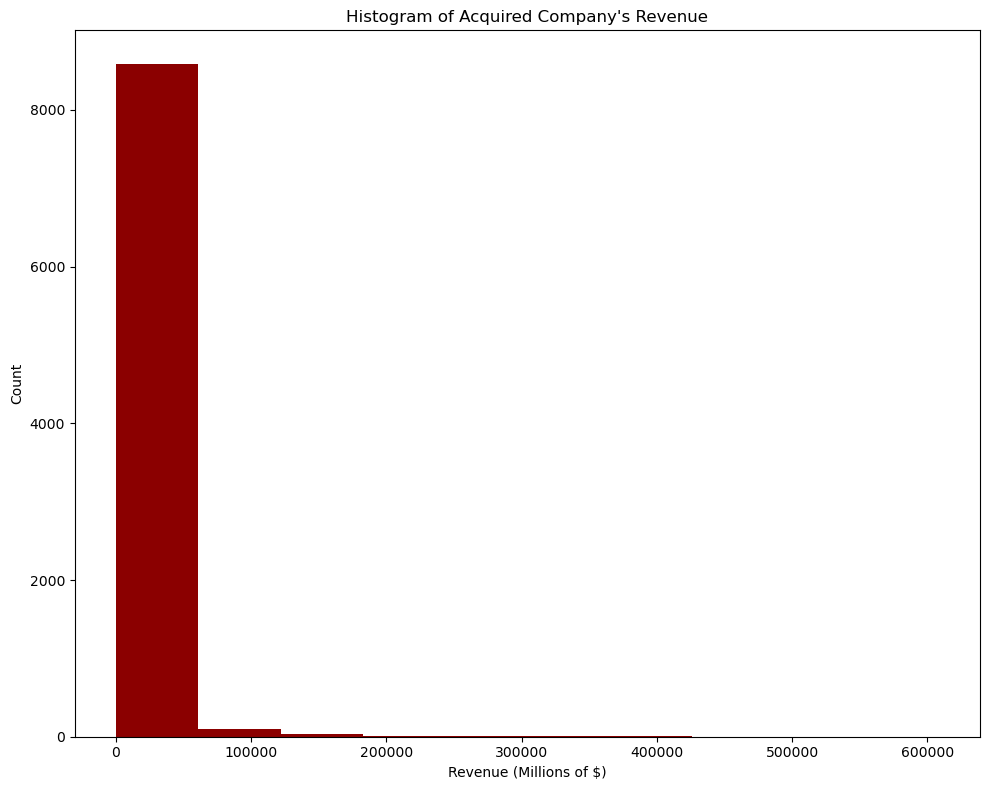

In [52]:

# drop the 6 rows that are missing ticker
gvkey = gvkey[gvkey['tic'].notnull()]

# lets create a graph or two visualizing the sizes of these companies involved in acquisitions
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.hist(gvkey['revt'], bins=10, color='darkred')
plt.title("Histogram of Acquired Company's Revenue")
plt.xlabel('Revenue (Millions of $)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# Merge gvkey on TNIC Dataset

In [53]:

# to properly merge the two datasets, lets create a name/ticker map
gvkey_name_map = gvkey[['gvkey', 'conm', 'tic']]

gvkey_name_map = gvkey_name_map.rename(columns={
    'gvkey': 'gvkey',
    'conm' : 'company_name',
    'tic' : 'ticker'
})

# merge tnic with firm side

tnic_named = tnic_2023.merge(
    gvkey_name_map,
    how='left',
    left_on='gvkey1',
    right_on='gvkey' 
).rename(columns={
    'company_name' : 'firm_name',
    'ticker' : 'firm_ticker'
}).drop('gvkey', axis=1)

# merge tnic with peer side
tnic_named = tnic_named.merge(
    gvkey_name_map, 
    how='left', 
    left_on='gvkey2',
    right_on='gvkey'
).rename(columns={
    'company_name' : 'peer_name',
    'ticker' : 'peer_ticker'
}).drop('gvkey', axis=1)

tnic_named = tnic_named[[
    'year', 'gvkey1', 'firm_name', 'firm_ticker', 'gvkey2', 'peer_name', 'peer_ticker', 'score'
]]

tnic_named.head()

,year,gvkey1,firm_name,firm_ticker,gvkey2,peer_name,peer_ticker,score
0,2023,1004,AAR CORP,AIR,1823,ASTRONICS CORP,ATRO,0.0127
1,2023,1004,AAR CORP,AIR,4091,DUCOMMUN INC,DCO,0.0087
2,2023,1004,AAR CORP,AIR,5567,HEICO CORP,HEI,0.0063
3,2023,1004,AAR CORP,AIR,9698,SIFCO INDUSTRIES,SIF,0.0075
4,2023,1004,AAR CORP,AIR,10519,TEXTRON INC,TXT,0.0191


# Explore Peer Similarity Scores
+ Rank firms by pairwise score

In [54]:

# engieer a feature that ranks all peer firms for each focal firm by their TNIC pairwise score
tnic_named['peer_rank'] = (
    tnic_named.groupby('firm_ticker')['score']
    .rank(method='first', ascending=False)
)

# n defines how many top peers to keep per firm, e.g 10 means top 10 most similar peers
n = 10 # could be changed to whatever number desires

# filter TNIC df to retain only the top N peers for each firm
top_n_peers = tnic_named[tnic_named['peer_rank'] <= n].copy()

# count how many top peers each firm actually received (some may have < N due to data limits)
peer_counts = top_n_peers.groupby('firm_ticker')['peer_rank'].count()
print(peer_counts.head())

firm_ticker
A       10
AA       2
AAGR    10
AAL     10
AAME    10
Name: peer_rank, dtype: int64


In [55]:

# lets check a mega-company like Apple and see what TNIC thinks its closest peer firms are:
top_n_peers[top_n_peers['firm_ticker'] == 'AAPL']


,year,gvkey1,firm_name,firm_ticker,gvkey2,peer_name,peer_ticker,score,peer_rank
2760,2023,1690,APPLE INC,AAPL,31843,HARMONIC INC,HLIT,0.0051,4.0
2761,2023,1690,APPLE INC,AAPL,33767,SONOS INC,SONO,0.0077,3.0
2762,2023,1690,APPLE INC,AAPL,37090,CORSAIR GAMING INC,CRSR,0.0209,2.0
2763,2023,1690,APPLE INC,AAPL,102696,LOGITECH INTERNATIONAL SA,LOGI,0.0212,1.0


# Apple Peer Firms Analyzed
+ TNIC believes that AAPL is closest to these four firms
    + Takes into account 10-K similarity to other companies
    + Infers that APPL's 10-K contains langauge that aligns closer to HLIT, SONO, CRSR, and LOGI
    + Other mega-companies might've been filtered out due to diverging 10-Ks
    + Important to temper expectations and understand what is being computed in score and peer_rank
+ Lets check companies that have been recently acquired:
    + Pioneer Natural Resources Acq. by Exxon Mobile
    + Seagen Acq. by Pfizer
    + VMWare Acq. by Broadcom



In [56]:

# top peers of PXD
top_n_peers[top_n_peers['firm_ticker'] == 'PXD']


,year,gvkey1,firm_name,firm_ticker,gvkey2,peer_name,peer_ticker,score,peer_rank
74766,2023,14359,PIONEER NATURAL RESOURCES CO,PXD,6311,PRIMEENERGY RESOURCES CORP,PNRG,0.1156,2.0
74771,2023,14359,PIONEER NATURAL RESOURCES CO,PXD,10938,US ENERGY CORP,USEG,0.0494,5.0
74772,2023,14359,PIONEER NATURAL RESOURCES CO,PXD,10938,US ENERGY CORP,USEG,0.0494,6.0
74774,2023,14359,PIONEER NATURAL RESOURCES CO,PXD,14934,DEVON ENERGY CORP,DVN,0.1233,1.0
74776,2023,14359,PIONEER NATURAL RESOURCES CO,PXD,16478,EOG RESOURCES INC,EOG,0.0456,7.0
74779,2023,14359,PIONEER NATURAL RESOURCES CO,PXD,20534,VIPER ENERGY INC,VNOM,0.0450,8.0
74782,2023,14359,PIONEER NATURAL RESOURCES CO,PXD,26013,SM ENERGY CO,SM,0.0641,4.0
74786,2023,14359,PIONEER NATURAL RESOURCES CO,PXD,30145,PROPETRO HOLDING CORP,PUMP,0.0735,3.0
74791,2023,14359,PIONEER NATURAL RESOURCES CO,PXD,41797,TXO ENERGY PARTNERS LP,TXO,0.0374,10.0
74793,2023,14359,PIONEER NATURAL RESOURCES CO,PXD,142337,NORTHERN OIL & GAS INC,NOG,0.0432,9.0


In [57]:

# top peers of Seagen
top_n_peers[top_n_peers['firm_ticker'] == 'SGEN']

,year,gvkey1,firm_name,firm_ticker,gvkey2,peer_name,peer_ticker,score,peer_rank


In [58]:

# top peers of VMWare
top_n_peers[top_n_peers['firm_ticker'] == 'VMW']

,year,gvkey1,firm_name,firm_ticker,gvkey2,peer_name,peer_ticker,score,peer_rank
964802,2023,178083,VMWARE INC -CL A,VMW,2573,CSP INC,CSPI,0.0760,8.0
964804,2023,178083,VMWARE INC -CL A,VMW,12141,MICROSOFT CORP,MSFT,0.0826,6.0
964805,2023,178083,VMWARE INC -CL A,VMW,12142,ORACLE CORP,ORCL,0.0760,9.0
964809,2023,178083,VMWARE INC -CL A,VMW,19849,A10 NETWORKS INC,ATEN,0.0812,7.0
964813,2023,178083,VMWARE INC -CL A,VMW,20779,CISCO SYSTEMS INC,CSCO,0.0866,5.0
964819,2023,178083,VMWARE INC -CL A,VMW,26746,NUTANIX INC,NTNX,0.1163,1.0
964821,2023,178083,VMWARE INC -CL A,VMW,30736,OKTA INC,OKTA,0.1009,2.0
964860,2023,178083,VMWARE INC -CL A,VMW,121077,F5 INC,FFIV,0.0981,3.0
964861,2023,178083,VMWARE INC -CL A,VMW,121718,JUNIPER NETWORKS INC,JNPR,0.0727,10.0
964868,2023,178083,VMWARE INC -CL A,VMW,171067,PALO ALTO NETWORKS INC,PANW,0.0895,4.0


# Breakdown of the Top Peers of PXD, SGEN, & VMW
+ **PXD**
    + Pairwise Peers:  
        + TXO - 10.0
        + NOG - 9.0
        + VNOM - 8.0
        + EOG - 7.0
    + Selected Companies:
        + COP 
        + DVN
        + FANG 
        + EOG
        + OXY

# Create Seamless Dictionary for Peer Lookups

In [59]:
tnic_peer_dict = (
    top_n_peers.groupby('firm_ticker')['peer_ticker']
    .apply(list)
    .to_dict()
)

# quick way to grab peers for AAPL
print('Apple TNIC Peers: ', tnic_peer_dict.get('AAPL'))

# or PXD
print('PXD TNIC peers: ', tnic_peer_dict.get('PXD'))

Apple TNIC Peers:  ['HLIT', 'SONO', 'CRSR', 'LOGI']
PXD TNIC peers:  ['PNRG', 'USEG', 'USEG', 'DVN', 'EOG', 'VNOM', 'SM', 'PUMP', 'TXO', 'NOG']


# K Clustering Exploration


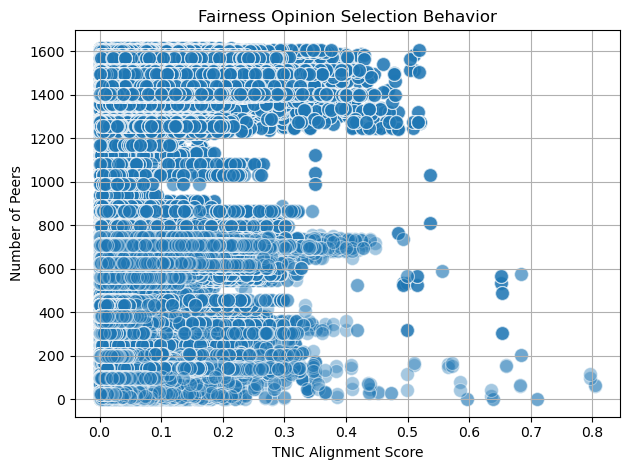

In [ ]:

# engineer column for counting peers per firm
tnic_named['count'] = tnic_named.groupby('firm_ticker')['peer_rank'].transform('count')

# import necessary packages
import seaborn as sns
import matplotlib.pyplot as plt

# plot
sns.scatterplot(
    data=tnic_named,
    x='score',
    y='count',
    alpha=0.4,
    s=100,
)

plt.title('Fairness Opinion Selection Behavior')
plt.xlabel('TNIC Alignment Score')
plt.ylabel('Number of Peers')
plt.grid(True)
plt.tight_layout()
plt.show()

# Furter Feature Engineering

+ Create some more features surrounding score and peer counts
+ Normalized rank of scores among firm's peers
+ Group some of the metrics together
    + Mean, max, std


In [70]:


# compute normalized rank percentile for each peer relationship
tnic_named['rank_pct'] = tnic_named['peer_rank'] / tnic_named['count']

# group firm-level aggregates across all peers
firm_clustering_df = tnic_named.groupby('firm_ticker').agg({
    'score': ['mean', 'max', 'std'],
    'rank_pct': 'mean',
    'peer_rank': 'count'
})

# flatten multi-index columns created prior
firm_clustering_df.columns = [
    'score_mean', 'score_max', 'score_std',
    'rank_pct_mean', 'tnic_peer_count'
]
firm_clustering_df = firm_clustering_df.reset_index()

# compute score dropoff between top 1 and 2 peers
top2 = tnic_named[tnic_named['peer_rank'] <= 2].copy()
dropoff = top2.pivot(index='firm_ticker', columns='peer_rank', values='score') \
              .rename(columns={1.0: 'score1', 2.0: 'score2'})
dropoff['score_dropoff_1_2'] = dropoff['score1'] - dropoff['score2']

firm_clustering_df = firm_clustering_df.merge(
    dropoff[['score_dropoff_1_2']],
    on='firm_ticker',
    how='left'
)

# count number of strong TNIC peers (score >= 0.1)
strong_peers = tnic_named[tnic_named['score'] >= 0.1] \
    .groupby('firm_ticker') \
    .size() \
    .rename('num_strong_peers')

firm_clustering_df = firm_clustering_df.merge(
    strong_peers,
    on='firm_ticker',
    how='left'
).fillna({'num_strong_peers': 0})

# create alternative df for optimal data cleanliness
firm_clustering_df_clean = firm_clustering_df.dropna()


/var/folders/g1/5jyzgjs54vj6npmtcwwyq7cr0000gn/T/ipykernel_95906/263929736.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firm_clustering_df_clean['cluster'] = kmeans.fit_predict(X_scaled)
/var/folders/g1/5jyzgjs54vj6npmtcwwyq7cr0000gn/T/ipykernel_95906/263929736.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firm_clustering_df_clean['pca1'] = components[:, 0]
/var/folders/g1/5jyzgjs54vj6npmtcwwyq7cr0000gn/T/ipykernel_95906/263929736.py:18: SettingWithCopyWarning: 
A value is trying to be set on

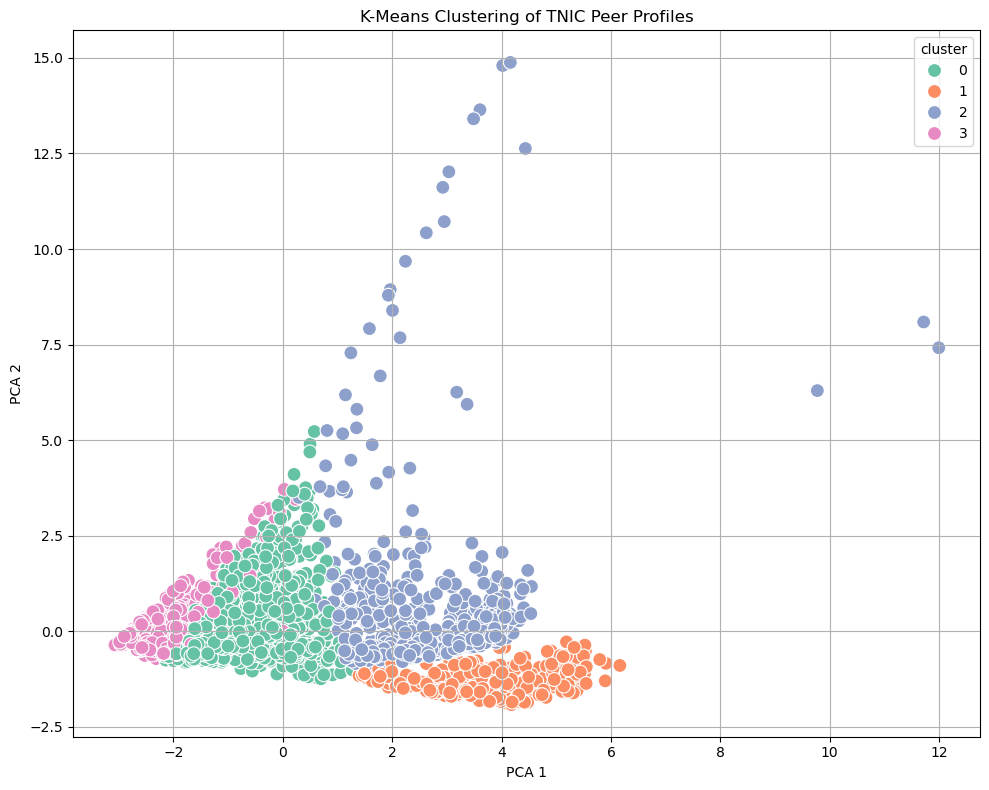

In [ ]:

# import necessary packages
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# scale all score data to µ: 0, σ: 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(firm_clustering_df_clean.drop(columns='firm_ticker'))

# initialize clustering and apply clusters to data
kmeans = KMeans(n_clusters=4, random_state=617)
firm_clustering_df_clean['cluster'] = kmeans.fit_predict(X_scaled).copy()

# initialize pca and apply to df
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# transpose pca onto df
firm_clustering_df_clean['pca1'] = components[:, 0]
firm_clustering_df_clean['pca2'] = components[:, 1]

# graph clusters with PCA
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=firm_clustering_df_clean,
    x='pca1', 
    y='pca2',
    hue='cluster',
    palette='Set2',
    s=100
)

plt.title('K-Means Clustering of TNIC Peer Profiles')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.tight_layout()
plt.show()

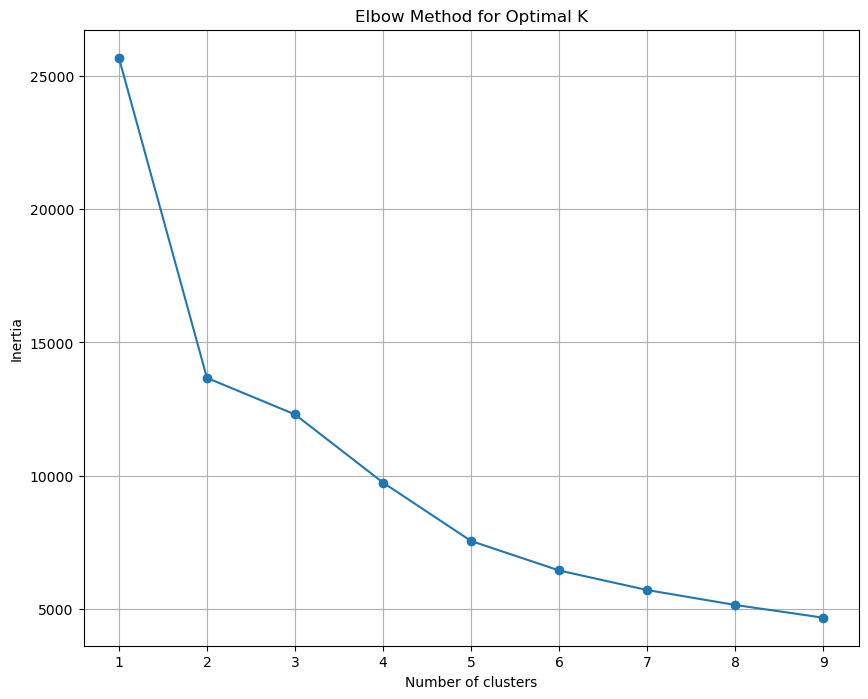

In [ ]:

# tune the amount of clusters with elbow method
inertias = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=617)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# plot
plt.figure(figsize=(10,8))
plt.plot(K, inertias, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [ ]:

# copy df to universal variable
X = firm_clustering_df.drop(columns='firm_ticker')

# from elbow method we can either use 2-4 clusters
kmeans = KMeans(n_clusters=3, random_state=617)
firm_clustering_df_clean['cluster'] = kmeans.fit_predict(X_scaled)

# reduce dimensionalization using PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
firm_clustering_df_clean['pca1'] = X_pca[:, 0]
firm_clustering_df_clean['pca2'] = X_pca[:, 1]

# be able to identify outliers within graph through distance comparisons
import numpy as np
centroids_2d = pd.DataFrame(pca.transform(kmeans.cluster_centers_), columns=['pca1', 'pca2'])
distances = np.linalg.norm(X_pca - centroids_2d.values[firm_clustering_df_clean['cluster']], axis=1)

# data points in 95th percentile will be flagged
firm_clustering_df_clean['outlier'] = distances > np.percentile(distances, 95)

# pop. dictionary with all PCA loadings
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=['PCA1', 'PCA2'],
).sort_values('PCA1', ascending=False)

print('PCA Top variables:')
print(loadings)

PCA Top variables:
                       PCA1      PCA2
score_mean         0.458815 -0.017085
score_max          0.447093  0.266769
num_strong_peers   0.429245 -0.258883
tnic_peer_count    0.416747 -0.302844
score_std          0.408436  0.321457
score_dropoff_1_2  0.033488  0.806231
rank_pct_mean     -0.252440  0.128313


/var/folders/g1/5jyzgjs54vj6npmtcwwyq7cr0000gn/T/ipykernel_95906/1236392142.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firm_clustering_df_clean['cluster'] = kmeans.fit_predict(X_scaled)
/var/folders/g1/5jyzgjs54vj6npmtcwwyq7cr0000gn/T/ipykernel_95906/1236392142.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firm_clustering_df_clean['pca1'] = X_pca[:, 0]
/var/folders/g1/5jyzgjs54vj6npmtcwwyq7cr0000gn/T/ipykernel_95906/1236392142.py:11: SettingWithCopyWarning: 
A value is trying to be set on a 

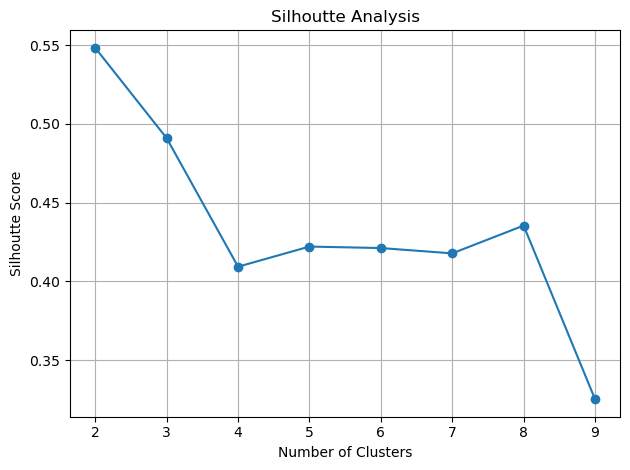

In [ ]:

# import necessary packages
from sklearn.metrics import silhouette_score

# create list for sil. scores per n_cluster
sil_scores = []
K_range = range(2,10)

# loop through each number in K_range
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=617)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

# plot 
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Analysis')
plt.grid(True)
plt.tight_layout()
plt.show()

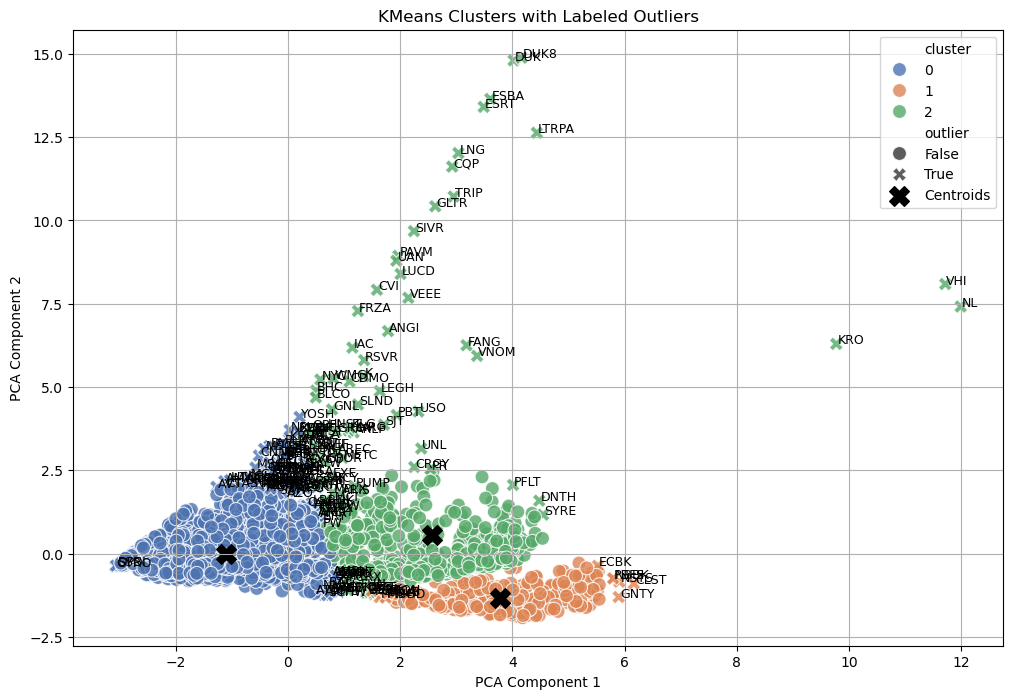

In [ ]:

# grab only the outliers and put them into a list
outliers = firm_clustering_df_clean[firm_clustering_df_clean['outlier']]

# plot all points from pca with n_clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=firm_clustering_df_clean,
    x='pca1',
    y='pca2',
    hue='cluster',
    style='outlier',
    palette='deep',
    s=100,
    alpha=0.8
)

# plot centroids (concentrations of clusters)
plt.scatter(
    centroids_2d['pca1'],
    centroids_2d['pca2'],
    c='black',
    marker='X',
    s=200,
    label='Centroids'
)

# add labels for all outliers
for _, row in outliers.iterrows():
    plt.text(row['pca1'] + 0.02, row['pca2'], row['firm_ticker'], fontsize=9)

plt.title('KMeans Clusters with Labeled Outliers')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()